In [ ]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications import VGG16
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.applications import imagenet_utils
from tensorflow.keras.models import Model
import os
from sklearn import preprocessing
from random import shuffle
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Activation, Dropout, Conv2D, MaxPooling2D
from random import randint
import h5py
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.utils import img_to_array
from tensorflow.keras.models import Sequential, model_from_json
from tensorflow.keras.callbacks import TensorBoard
import time
import pickle
import numpy as np
import imutils
import cv2

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

!pip install unrar
import unrar
!unrar x '/content/drive/MyDrive/Yolov5 Formatted Data (with test).rar'

Streaming output truncated to the last 5000 lines.
Extracting  Yolo Formatted Data (with test)/labels/train/5722_0317115034_01_WRI-R2_F013.txt      99%  OK 
Extracting  Yolo Formatted Data (with test)/labels/train/5723_0248151065_01_WRI-R1_F012.txt      99%  OK 
Extracting  Yolo Formatted Data (with test)/labels/train/5723_0248151099_01_WRI-R2_F012.txt      99%  OK 
Extracting  Yolo Formatted Data (with test)/labels/train/5724_0753805015_01_WRI-R1_M004.txt      99%  OK 
Extracting  Yolo Formatted Data (with test)/labels/train/5725_0537135025_01_WRI-R1_F017.txt      99%  OK 
Extracting  Yolo Formatted Data (with test)/labels/train/5725_0538330523_02_WRI-R2_F017.txt      99%  OK 
Extracting  Yolo Formatted Data (with test)/labels/train/5726_0957811427_01_WRI-L1_M011.txt      99%  OK 
Extracting  Yolo Formatted Data (with test)/labels/train/5726_0957811462_01_WRI-L2_M011.txt      99%  OK 
Extracting  Yolo Formatted Da

In [ ]:
import os
import csv
import shutil

def copy_files(folder_directory, csv_path, output_directory):
    # Create output directory if it doesn't exist
    if not os.path.exists(output_directory):
        os.makedirs(output_directory)

    # Read the CSV file
    with open(csv_path, 'r') as csv_file:
        reader = csv.DictReader(csv_file, delimiter=',')
        for row in reader:
            filestem = row[reader.fieldnames[0]]  # Extract the value from the first column
            fracture_visible = row[reader.fieldnames[13]]  # Assuming the second column contains fracture_visible value

            if not filestem.endswith('.png'):
                filestem += '.png'

            # Determine the source folder based on the fracture_visible value
            if fracture_visible == '1':
                destination_folder = '1'
            else:
                destination_folder = '0'

            # Search for the file in the train, test, and val folders
            for folder_name in ['train', 'test', 'val']:
                source_path = os.path.join(folder_directory, folder_name, filestem)
                if os.path.exists(source_path):
                    break

            print(f"source path: {source_path}")
            if os.path.exists(source_path):
                destination_path = os.path.join(output_directory, destination_folder, filestem)
                os.makedirs(os.path.dirname(destination_path), exist_ok=True)
                shutil.copy(source_path, destination_path)
                print(f"Copied {filestem} to {destination_path}")
            else:
                print(f"File {filestem} not found in any folder")

folder_directory = '/content/Yolo Formatted Data (with test)/images'
csv_path = '/content/drive/MyDrive/dataset.csv'
output_directory = '/content/dataset'

copy_files(folder_directory, csv_path, output_directory)

Streaming output truncated to the last 5000 lines.
source path: /content/Yolo Formatted Data (with test)/images/train/5328_0387304575_01_WRI-L2_F011.png
Copied 5328_0387304575_01_WRI-L2_F011.png to /content/dataset/0/5328_0387304575_01_WRI-L2_F011.png
source path: /content/Yolo Formatted Data (with test)/images/test/5328_0476911826_02_WRI-R1_F014.png
Copied 5328_0476911826_02_WRI-R1_F014.png to /content/dataset/0/5328_0476911826_02_WRI-R1_F014.png
source path: /content/Yolo Formatted Data (with test)/images/train/5328_0476911872_02_WRI-R2_F014.png
Copied 5328_0476911872_02_WRI-R2_F014.png to /content/dataset/0/5328_0476911872_02_WRI-R2_F014.png
source path: /content/Yolo Formatted Data (with test)/images/train/5329_0558345445_01_WRI-L1_F004.png
Copied 5329_0558345445_01_WRI-L1_F004.png to /content/dataset/1/5329_0558345445_01_WRI-L1_F004.png
source path: /content/Yolo Formatted Data (with test)/images/test/5329_0558345475_01_WRI-L2_F004.png
Copied 5329_0558345475_01_WRI-L2_F004.png to 

In [ ]:
print("0", len(os.listdir('/content/dataset/0')))
print("1", len(os.listdir('/content/dataset/1')))

0 6777
1 13549


In [ ]:
import os
import shutil
import random

def create_data_split(folder_directory, train_ratio=0.75, test_ratio=0.05, val_ratio=0.2):
    data_folder = os.path.join(folder_directory, 'data')
    if not os.path.exists(data_folder):
        os.makedirs(data_folder)
    else:
        print("The 'data' folder already exists. Please remove or rename it.")
        return

    subfolders = ['0', '1']
    subfolder_paths = [os.path.join(folder_directory, subfolder) for subfolder in subfolders]

    # Create the train, test, and val folders
    for split in ['train', 'test', 'val']:
        split_folder = os.path.join(data_folder, split)
        os.makedirs(split_folder)
        for subfolder in subfolders:
            class_folder = os.path.join(split_folder, subfolder)
            os.makedirs(class_folder)

    # Split the data
    for subfolder_path in subfolder_paths:
        images = os.listdir(subfolder_path)
        random.shuffle(images)

        train_end = int(len(images) * train_ratio)
        test_end = train_end + int(len(images) * test_ratio)

        train_images = images[:train_end]
        test_images = images[train_end:test_end]
        val_images = images[test_end:]

        for image in train_images:
            src = os.path.join(subfolder_path, image)
            dst = os.path.join(data_folder, 'train', os.path.basename(subfolder_path), image)
            shutil.copy(src, dst)

        for image in test_images:
            src = os.path.join(subfolder_path, image)
            dst = os.path.join(data_folder, 'test', os.path.basename(subfolder_path), image)
            shutil.copy(src, dst)

        for image in val_images:
            src = os.path.join(subfolder_path, image)
            dst = os.path.join(data_folder, 'val', os.path.basename(subfolder_path), image)
            shutil.copy(src, dst)

    print("Data split completed successfully!")

folder_directory = '/content/dataset'
create_data_split(folder_directory)

Data split completed successfully!


In [ ]:
# Just some helper methods, that we will use later down the road

def resize_image(img_array, height, width):
    return cv.resize(img_array, (height, width))

def plot_image(img_array):
    plt.imshow(img_array, cmap='gray')
    plt.show()

In [ ]:
img_height = 120
img_width = 50
classes = ['0', '1']
class_names = ['No-Fracture', 'Fracture']

In [ ]:
print("Train 0", len(os.listdir("/content/dataset/data/train/0")))
print("Train 1", len(os.listdir("/content/dataset/data/train/1")))
print("Val 0", len(os.listdir("/content/dataset/data/val/0")))
print("Val 1", len(os.listdir("/content/dataset/data/val/1")))
print("Test 0", len(os.listdir("/content/dataset/data/test/0")))
print("Test 1", len(os.listdir("/content/dataset/data/test/1")))

Train 0 5082
Train 1 10161
Val 0 1357
Val 1 2711
Test 0 338
Test 1 677


In [ ]:
!rm -rf "/content/Yolo Formatted Data (with test)"

In [ ]:
data_dir = '/content/dataset/data/train'

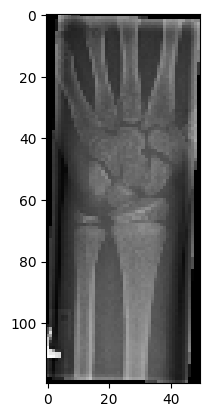

In [ ]:
img_index = randint(0, 3000)
class_index = randint(0, 1)

img = cv.imread(os.path.join(os.path.join(data_dir, classes[class_index]),
                             os.listdir(os.path.join(data_dir, classes[class_index]))[img_index]), cv.IMREAD_GRAYSCALE)
r_img = resize_image(img, img_width, img_height)

plt.imshow(r_img, cmap='gray')
plt.show()

In [ ]:
# Creating training data
def get_data(data_dir, classes, img_width, img_height):
    data = []
    for a_class in classes:
        path = os.path.join(data_dir, a_class)
        class_num = classes.index(a_class)

        for image in os.listdir(path):
            try:
              img_array = cv.imread(os.path.join(path, image), cv.IMREAD_GRAYSCALE)
              resized_img_array = resize_image(img_array, img_width, img_height)
              data.append([resized_img_array, class_num])
            except:
              continue

    return data

In [ ]:
training_data = get_data(data_dir, classes, img_width, img_height)
# Shuffling the training data (IMPORTANT)
shuffle(training_data)

In [ ]:
# Seperating features from the labels
def sep_features_labels(data):
    X = []
    y = []
    for features, label in data:
        X.append(features)
        y.append(label)
    return X, y

In [ ]:
X_train, y_train = sep_features_labels(training_data)

In [ ]:
#Reshaping the features
def reshape(X, y, img_width, img_height):
    X = np.array(X).reshape(-1, img_height, img_width, 1)
    X = np.array(X).astype('float')/255.0
    # y_train = preprocessing.LabelEncoder().fit_transform(y_train)
    y = np.asarray(y).astype('float32').reshape((-1,1))

    return X, y

In [ ]:
X_train, y_train = reshape(X_train, y_train, img_width, img_height)

In [ ]:
def pickle_save(x_name, y_name, X, y):
    pickle_out = open(f'{x_name}.pickle', "wb")
    pickle.dump(X, pickle_out)
    pickle_out.close()

    pickle_out = open(f'{y_name}.pickle', 'wb')
    pickle.dump(y, pickle_out)
    pickle_out.close()

def pickle_load(x_name, y_name):
    pickle_in = open(x_name, 'rb')
    X = pickle.load(pickle_in)
    pickle_in.close()

    pickle_in = open(y_name, 'rb')
    y = pickle.load(pickle_in)
    pickle_in.close()
    return X, y

In [ ]:
def getConvModel(input_shape, num_kernels, hidden_neurons, num_layers):
    model = Sequential()
    model.add(Conv2D(32, (3, 3), input_shape=input_shape, activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))

    # for i in range(0, num_layers - 1):
    model.add(Conv2D(32, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(128, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.5))
#     model.add(Dense(hidden_neurons, activation='relu'))

    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss="binary_crossentropy", optimizer='adam', metrics=["accuracy"])
    return model

In [ ]:
conv_model = getConvModel(X_train.shape[1:], 64, 128, 4)

In [ ]:
val_data = get_data('/content/dataset/data/val', classes, img_width, img_height)
shuffle(val_data)
X_val, y_val = sep_features_labels(val_data)
X_val, y_val = reshape(X_val, y_val, img_width, img_height)

In [ ]:
print(len(X_val), len(y_val))

4068 4068


In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
checkpoint_filepath = '/content/drive/MyDrive/checkpoint.h5'

# Create the ModelCheckpoint callback
checkpoint_callback = ModelCheckpoint(
    checkpoint_filepath,
    monitor='val_accuracy',
    save_weights_only=False,
    save_best_only=True,  # Save only the best model based on validation loss
    save_freq='epoch',
    verbose=1
)

# Define early stopping criteria
early_stopping = EarlyStopping(
    monitor='val_accuracy',
    patience=15,  # Number of epochs with no improvement after which training will be stopped
    restore_best_weights=True  # Restore the weights of the best model found during training
)

# Train the model with the checkpoint and early stopping callbacks
history = conv_model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    batch_size=132,
    epochs=100,
    verbose=1,
    callbacks=[checkpoint_callback, early_stopping]
)

Epoch 1/100
116/116 [==============================] - ETA: 0s - loss: 0.5631 - accuracy: 0.7010
Epoch 1: val_accuracy improved from -inf to 0.66642, saving model to /content/drive/MyDrive/checkpoint.h5
116/116 [==============================] - 20s 40ms/step - loss: 0.5631 - accuracy: 0.7010 - val_loss: 0.6526 - val_accuracy: 0.6664
Epoch 2/100
115/116 [============================>.] - ETA: 0s - loss: 0.5030 - accuracy: 0.7515
Epoch 2: val_accuracy did not improve from 0.66642
116/116 [==============================] - 3s 23ms/step - loss: 0.5032 - accuracy: 0.7514 - val_loss: 0.6242 - val_accuracy: 0.6664
Epoch 3/100
114/116 [============================>.] - ETA: 0s - loss: 0.4771 - accuracy: 0.7677
Epoch 3: val_accuracy improved from 0.66642 to 0.67748, saving model to /content/drive/MyDrive/checkpoint.h5
116/116 [==============================] - 3s 24ms/step - loss: 0.4771 - accuracy: 0.7674 - val_loss: 0.5940 - val_accuracy: 0.6775
Epoch 4/100
116/116 [=========================

In [ ]:
# Save the final model
final_model_filepath = '/content/drive/MyDrive/final_model.h5'
conv_model.save(final_model_filepath)

# Save the history object
history_filepath = '/content/drive/MyDrive/history.pkl'
import pickle
with open(history_filepath, 'wb') as f:
    pickle.dump(history.history, f)

print("Model and history saved successfully!")

In [ ]:
from tensorflow import keras

conv_model = '/content/drive/MyDrive/checkpoint.h5'

# Load the model
conv_model = keras.models.load_model(conv_model)

In [ ]:
def load_img(img_path):
  img_array = cv.imread(img_path, cv.IMREAD_GRAYSCALE)
  try:
    img_array = cv.resize(img_array, (img_width, img_height))
  except:
    pass
  plt.imshow(img_array)
  img_array = np.array(img_array).reshape(-1, img_height, img_width, 1)
  img_array = (np.array(img_array)).astype('float')/255.0
  return img_array

In [ ]:
class GradCAM:
    def __init__(self, model, classIdx, layerName=None):
        # store the model, the class index used to measure the class
        # activation map, and the layer to be used when visualizing
        # the class activation map
        self.model = model
        self.classIdx = classIdx
        self.layerName = layerName

        # if the layer name is None, attempt to automatically find
        # the target output layer
        if self.layerName is None:
            self.layerName = self.find_target_layer()

    def find_target_layer(self):
        # attempt to find the final convolutional layer in the network
        # by looping over the layers of the network in reverse order
        for layer in reversed(self.model.layers):
            # check to see if the layer has a 4D output
            if len(layer.output.shape) == 4:
                return layer.name

        # otherwise, we could not find a 4D layer so the GradCAM
        # algorithm cannot be applied
        raise ValueError("Could not find 4D layer. Cannot apply GradCAM.")

    def compute_heatmap(self, image, eps=1e-8):
        # construct our gradient model by supplying (1) the inputs
        # to our pre-trained model, (2) the output of the (presumably)
        # final 4D layer in the network, and (3) the output of the
        # softmax activations from the model
        gradModel = Model(inputs=[self.model.inputs], outputs= [self.model.get_layer(self.layerName).output, self.model.output])

        # record operations for automatic differentiation
        with tf.GradientTape() as tape:
            # cast the image tensor to a float-32 data type, pass the
            # image through the gradient model, and grab the loss
            # associated with the specific class index
            inputs = tf.cast(image, tf.float32)
            (convOutputs, predictions) = gradModel(inputs)
            loss = predictions[:, self.classIdx]

        # use automatic differentiation to compute the gradients
        grads = tape.gradient(loss, convOutputs)

        # compute the guided gradients
        castConvOutputs = tf.cast(convOutputs > 0, "float32")
        castGrads = tf.cast(grads > 0, "float32")
        guidedGrads = castConvOutputs * castGrads * grads

        # the convolution and guided gradients have a batch dimension
        # (which we don't need) so let's grab the volume itself and
        # discard the batch
        convOutputs = convOutputs[0]
        guidedGrads = guidedGrads[0]

        # compute the average of the gradient values, and using them
        # as weights, compute the ponderation of the filters with
        # respect to the weights
        weights = tf.reduce_mean(guidedGrads, axis=(0, 1))
        cam = tf.reduce_sum(tf.multiply(weights, convOutputs), axis=-1)

        # grab the spatial dimensions of the input image and resize
        # the output class activation map to match the input image
        # dimensions
        (w, h) = (image.shape[2], image.shape[1])
        heatmap = cv2.resize(cam.numpy(), (w, h))

        # normalize the heatmap such that all values lie in the range
        # [0, 1], scale the resulting values to the range [0, 255],
        # and then convert to an unsigned 8-bit integer
        numer = heatmap - np.min(heatmap)
        denom = (heatmap.max() - heatmap.min()) + eps
        heatmap = numer / denom
        heatmap = (heatmap * 255).astype("uint8")

        # return the resulting heatmap to the calling function
        return heatmap

    def overlay_heatmap(self, heatmap, image, alpha=0.5,
        colormap=cv2.COLORMAP_JET):
        # apply the supplied color map to the heatmap and then
        # overlay the heatmap on the input image
        heatmap = cv2.applyColorMap(heatmap, colormap)
        output = cv2.addWeighted(image, alpha, heatmap, 1 - alpha, 0)

        # return a 2-tuple of the color mapped heatmap and the output,
        # overlaid image
        return (heatmap, output)

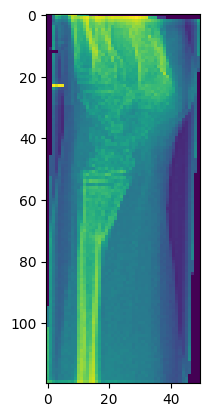

In [ ]:
img_index = randint(0, len(os.listdir("/content/dataset/data/test/1")))
class_index = randint(0, 1)
img = os.path.join("/content/dataset/data/test/1", os.listdir("/content/dataset/data/test/1")[img_index])
orig = cv2.imread(img)
resized = cv2.resize(orig, (120, 50))
image = load_img(img)

In [ ]:
preds = conv_model.predict(image)
i = np.argmax(preds[0])

1/1 [==============================] - 0s 23ms/step


In [ ]:
# decoded = imagenet_utils.decode_predictions(preds)
# (imagenetID, label, prob) = decoded[0][0]
# label = "{}: {:.2f}%".format(label, prob * 100)
# print("[INFO] {}".format(label))

In [ ]:
# initialize our gradient class activation map and build the heatmap
cam = GradCAM(conv_model, i)
heatmap = cam.compute_heatmap(image)
# resize the resulting heatmap to the original input image dimensions
# and then overlay heatmap on top of the image
heatmap = cv2.resize(heatmap, (orig.shape[1], orig.shape[0]))
(heatmap, output) = cam.overlay_heatmap(heatmap, orig, alpha=0.5)

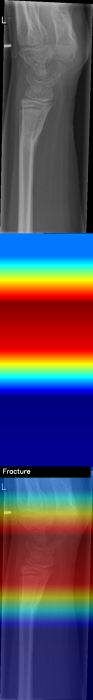

In [ ]:
from google.colab.patches import cv2_imshow
cv2.rectangle(output, (0, 0), (340, 40), (0, 0, 0), -1)
cv2.putText(output, "Fracture", (10, 25), cv2.FONT_HERSHEY_SIMPLEX, 0.8, (255, 255, 255), 2)

# display the original image and resulting heatmap and output image
# to our screen
output = np.vstack([orig, heatmap, output])
output = imutils.resize(output, height=700)
cv2_imshow(output)
cv2.waitKey(0)
cv2.destroyAllWindows()